In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [27]:
df = pd.read_csv('ndt_tests_corrigido.csv')

df.head()

,timestamp,download_throughput_bps,rtt_download_sec,upload_throughput_bps,rtt_upload_sec,packet_loss_percent,client,server
0,2025-08-09 15:28:02.000 +0000,8.223657e+07,0.231862,6.973217e+07,0.247727,0.000000,client12,server06
1,2025-08-09 15:30:11.000 +0000,9.027315e+08,0.012000,8.521780e+08,0.005423,0.008226,client01,server07
2,2025-08-10 04:27:43.000 +0000,5.910655e+08,0.014000,2.812188e+08,0.014544,5.954284,client13,server07
3,2025-08-09 22:45:07.000 +0000,6.721139e+08,0.011000,1.135400e+08,0.010482,0.261528,client12,server07
4,2025-08-10 04:49:21.000 +0000,8.122087e+08,0.009000,6.857905e+08,0.009368,1.381646,client03,server03


# Analyzing the data


In [28]:
df.describe()

,download_throughput_bps,rtt_download_sec,upload_throughput_bps,rtt_upload_sec,packet_loss_percent
count,7.087000e+03,7087.000000,7.087000e+03,7087.000000,7087.000000
mean,5.062996e+08,0.048447,3.781607e+08,0.037194,1.899137
std,3.352129e+08,0.067859,3.014096e+08,0.063537,3.449941
min,-1.000000e+00,-0.001000,-1.000000e+00,-1.000000,-1.000000
25%,1.642170e+08,0.008000,9.733497e+07,0.004918,0.001484
50%,5.960927e+08,0.011549,2.979242e+08,0.010858,0.189771
75%,8.489080e+08,0.115000,6.701694e+08,0.017723,2.050781
max,9.332671e+08,0.398051,9.214500e+08,0.360227,22.389090


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7087 entries, 0 to 7086
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                7087 non-null   object 
 1   download_throughput_bps  7087 non-null   float64
 2   rtt_download_sec         7087 non-null   float64
 3   upload_throughput_bps    7087 non-null   float64
 4   rtt_upload_sec           7087 non-null   float64
 5   packet_loss_percent      7087 non-null   float64
 6   client                   7087 non-null   object 
 7   server                   7087 non-null   object 
dtypes: float64(5), object(3)
memory usage: 443.1+ KB


# Data Preprocessing


In [30]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

metrics = [
    'download_throughput_bps',
    'rtt_download_sec',
    'upload_throughput_bps',
    'rtt_upload_sec',
    'packet_loss_percent'
]

# Clean the DataFrame
final_df = df.dropna(subset=metrics)
final_df = final_df[(final_df[metrics] >= 0).all(axis=1)]

# Apply log1p transformation to throughput metrics
for i in ['download_throughput_bps', 'upload_throughput_bps']:
    final_df[i] = np.log1p(final_df[i])


# Data visualization

In [31]:
date_min = df['timestamp'].min()
date_max = df['timestamp'].max()

print(f"The data collection interval was from {date_min} to {date_max}")

The data collection interval was from 2025-08-01 00:02:31+00:00 to 2025-08-30 23:54:52+00:00


In [32]:
df_group_client = final_df.groupby('client')
df_group_server = final_df.groupby('server')

Creating summary statistics and visualizations to better understand the data.

The download and upload throughput will use lower quantiles since we want to identify periods of low throughput, which indicate potential issues with network performance. Conversely, for RTT (latency) and packet loss, we will use higher quantiles to capture the worst-case scenarios that can significantly impact user experience.

In [33]:
stats = ['mean', 'median', 'var', 'std']

high_value_metrics = ['rtt_download_sec', 'rtt_upload_sec', 'packet_loss_percent']
high_quantiles = [90, 99]

low_value_metrics = ['download_throughput_bps', 'upload_throughput_bps']
low_quantiles = [10, 1]

summary_stats = {}
for metric in metrics:
    summary_stats[metric] = {}

    if metric in high_value_metrics:
        quantiles = high_quantiles
    elif metric in low_value_metrics:
        quantiles = low_quantiles
    else:
        quantiles = []

    agg_funcs = stats + [lambda x, q=q: np.percentile(x, q) for q in quantiles]

    # Estatísticas por cliente
    client_stats = df_group_client[metric].agg(agg_funcs)
    client_stats.columns = stats + [f'{q}th_percentile' for q in quantiles]
    summary_stats[metric]['by_client'] = client_stats

    # Estatísticas por servidor
    server_stats = df_group_server[metric].agg(agg_funcs)
    server_stats.columns = stats + [f'{q}th_percentile' for q in quantiles]
    summary_stats[metric]['by_server'] = server_stats

In [34]:
for metric in metrics:
    print(f"Summary statistics for {metric} by client:")
    display(summary_stats[metric]['by_client'])
    print("\n")

Summary statistics for download_throughput_bps by client:


,mean,median,var,std,10th_percentile,1th_percentile
client,,,,,,
client01,20.033650,20.609906,0.702878,0.838378,18.958553,17.803315
client02,20.020010,20.530065,0.746754,0.864149,18.953739,17.674765
client03,19.978899,20.515589,0.685019,0.827659,18.940108,17.964806
client04,19.886777,20.499621,0.777314,0.881654,18.903045,17.820783
client05,19.038318,18.487992,0.936916,0.967944,18.412504,17.714190
client06,19.952799,20.537732,0.750599,0.866371,18.954275,17.821412
client07,20.000356,20.542261,0.722358,0.849917,18.911526,17.857617
client08,18.770723,18.383980,0.749289,0.865615,18.144769,17.732482
client09,20.005309,20.611366,0.787428,0.887371,18.937299,17.825644




Summary statistics for rtt_download_sec by client:


,mean,median,var,std,90th_percentile,99th_percentile
client,,,,,,
client01,0.044897,0.011000,0.002887,0.053727,0.120452,0.125607
client02,0.039058,0.010000,0.002748,0.052420,0.118634,0.125138
client03,0.044533,0.010000,0.003163,0.056242,0.119974,0.219488
client04,0.051279,0.012000,0.003057,0.055291,0.122002,0.126632
client05,0.045166,0.010000,0.003010,0.054865,0.119000,0.219124
client06,0.046634,0.009941,0.003194,0.056514,0.118999,0.219149
client07,0.046375,0.013000,0.003322,0.057637,0.122670,0.223010
client08,0.054419,0.010000,0.004539,0.067369,0.120000,0.221000
client09,0.044974,0.010000,0.003012,0.054878,0.119566,0.218591




Summary statistics for upload_throughput_bps by client:


,mean,median,var,std,10th_percentile,1th_percentile
client,,,,,,
client01,20.234572,20.594154,0.412394,0.642179,19.031474,18.997054
client02,20.032027,20.260754,0.295376,0.543485,19.033968,18.971570
client03,19.946473,20.199404,0.311910,0.558489,19.026875,18.348755
client04,19.970981,20.246983,0.379440,0.615987,19.005239,18.961839
client05,19.165272,18.503132,0.927124,0.962873,18.379869,18.345758
client06,20.070101,20.420636,0.419385,0.647600,19.031917,18.349981
client07,19.878330,20.126997,0.448924,0.670018,18.995320,18.324134
client08,18.803806,18.393561,0.694014,0.833075,18.254675,17.625198
client09,19.199918,19.063623,2.341188,1.530094,17.166678,14.377140




Summary statistics for rtt_upload_sec by client:


,mean,median,var,std,90th_percentile,99th_percentile
client,,,,,,
client01,0.031305,0.006363,0.002170,0.046584,0.119980,0.122391
client02,0.029352,0.004243,0.002319,0.048154,0.117383,0.125348
client03,0.033029,0.004358,0.002557,0.050570,0.118955,0.188566
client04,0.037629,0.008354,0.002577,0.050763,0.121325,0.126393
client05,0.029707,0.004112,0.002236,0.047286,0.118595,0.120995
client06,0.033717,0.003862,0.002669,0.051658,0.118530,0.218561
client07,0.034484,0.008957,0.002657,0.051549,0.122368,0.223123
client08,0.040777,0.005875,0.003861,0.062137,0.120000,0.220907
client09,0.033937,0.004345,0.002561,0.050606,0.119106,0.123821




Summary statistics for packet_loss_percent by client:


,mean,median,var,std,90th_percentile,99th_percentile
client,,,,,,
client01,0.524093,0.005476,2.785163,1.668881,0.766485,8.454930
client02,0.781428,0.065453,3.533486,1.879757,1.813834,10.942418
client03,0.678094,0.074979,2.065939,1.437337,1.634429,7.178997
client04,0.522962,0.050632,1.730098,1.315332,1.142244,6.352281
client05,6.311938,8.276383,28.049796,5.296206,12.638444,15.008345
client06,0.833711,0.722961,1.035545,1.017617,1.835010,4.651602
client07,0.532497,0.088475,2.430100,1.558878,0.996650,7.440085
client08,5.060996,3.334843,36.956391,6.079177,18.473428,20.862316
client09,0.483263,0.073066,1.917653,1.384793,0.719826,7.600780


In [35]:
for metric in metrics:
    print(f"Summary statistics for {metric} by server:")
    display(summary_stats[metric]['by_server'])
    print("\n")

Summary statistics for download_throughput_bps by server:


,mean,median,var,std,10th_percentile,1th_percentile
server,,,,,,
server01,20.098653,20.451135,0.547415,0.739875,18.482923,18.236624
server02,20.064465,20.451236,0.646829,0.804257,18.475610,17.376733
server03,20.069281,20.459747,0.647773,0.804843,18.476060,17.828440
server04,18.811073,18.942495,0.529818,0.727886,18.138348,16.868657
server05,18.815301,18.944368,0.580255,0.761745,18.171215,16.830076
server06,18.829509,18.948932,0.580710,0.762043,18.109918,16.886187
server07,19.879217,20.379800,0.896726,0.946956,18.384504,17.421482




Summary statistics for rtt_download_sec by server:


,mean,median,var,std,90th_percentile,99th_percentile
server,,,,,,
server01,0.011294,0.011000,0.000005,0.002282,0.014420,0.017562
server02,0.011422,0.011000,0.000006,0.002543,0.015000,0.018663
server03,0.011467,0.011000,0.000006,0.002470,0.015000,0.018040
server04,0.127810,0.118387,0.004439,0.066625,0.223883,0.243329
server05,0.123079,0.118946,0.004574,0.067632,0.223493,0.241111
server06,0.129457,0.118846,0.005047,0.071042,0.227684,0.242667
server07,0.029630,0.009000,0.002881,0.053678,0.117000,0.229672




Summary statistics for upload_throughput_bps by server:


,mean,median,var,std,10th_percentile,1th_percentile
server,,,,,,
server01,19.460110,19.859248,1.201654,1.096200,17.631273,16.971686
server02,19.406551,19.880975,1.354740,1.163933,17.617153,16.812079
server03,19.454264,19.928696,1.285270,1.133697,17.626850,16.947806
server04,18.599199,19.019087,0.855555,0.924962,17.384494,15.008886
server05,18.639972,19.014871,0.639304,0.799565,17.427757,15.999151
server06,18.568277,19.016179,0.966511,0.983113,17.395907,14.702572
server07,19.508117,20.056190,1.150463,1.072596,17.851592,17.057530




Summary statistics for rtt_upload_sec by server:


,mean,median,var,std,90th_percentile,99th_percentile
server,,,,,,
server01,0.012636,0.011140,0.000016,0.004020,0.018974,0.023730
server02,0.013066,0.011247,0.000019,0.004302,0.020220,0.024679
server03,0.012940,0.011203,0.000019,0.004312,0.020076,0.025741
server04,0.129140,0.118841,0.004604,0.067852,0.231366,0.243249
server05,0.124031,0.118818,0.004738,0.068835,0.228080,0.248317
server06,0.130851,0.119007,0.005240,0.072386,0.232381,0.248000
server07,0.007645,0.005447,0.000026,0.005121,0.015244,0.019753




Summary statistics for packet_loss_percent by server:


,mean,median,var,std,90th_percentile,99th_percentile
server,,,,,,
server01,2.257183,1.016940,7.854041,2.802506,6.434744,11.242165
server02,1.990990,0.805588,8.143212,2.853631,6.285317,11.676974
server03,2.130031,0.835013,8.557466,2.925315,6.456412,11.528407
server04,1.944134,0.000000,15.793148,3.974059,6.357436,18.994956
server05,2.747088,0.000000,26.866777,5.183317,10.858315,20.345952
server06,1.952090,0.000000,17.984668,4.240833,6.416377,19.347260
server07,1.666748,0.089298,9.698873,3.114301,5.837980,13.482504


## Data visualization for client network performance metrics

We chose client05 because it exhibits extremely high packet loss (average packet_loss_percent ≈ 6.31%, with peaks above 15%), which is significantly higher than the other clients that remain below 1%. This makes it ideal for analyzing network instability, outliers, and the correlation between packet loss and reduced throughput.


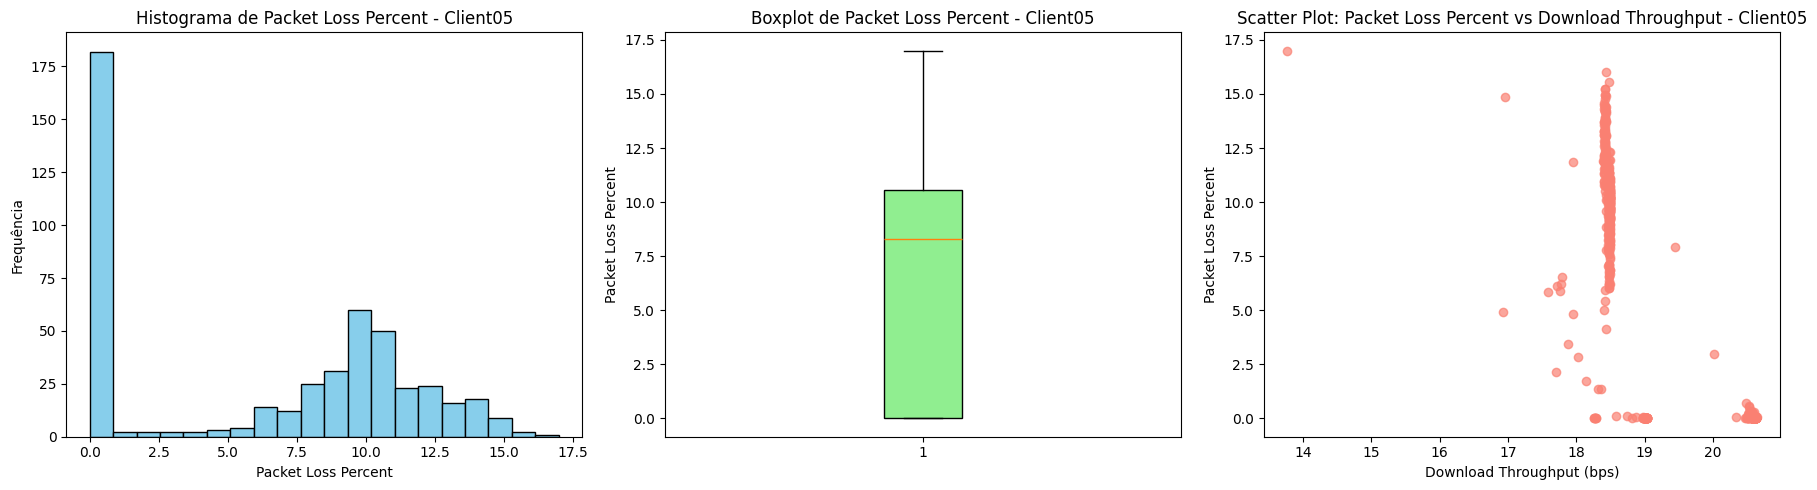

In [36]:
client05_data = final_df[final_df['client'] == 'client05']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
# Histograma
axs[0].hist(client05_data['packet_loss_percent'], bins=20, color='skyblue', edgecolor='black')
axs[0].set_title('Histograma de Packet Loss Percent - Client05')
axs[0].set_xlabel('Packet Loss Percent')
axs[0].set_ylabel('Frequência')
# Boxplot
axs[1].boxplot(client05_data['packet_loss_percent'], vert=True, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axs[1].set_title('Boxplot de Packet Loss Percent - Client05')
axs[1].set_ylabel('Packet Loss Percent')
# Scatter plot
axs[2].scatter(client05_data['download_throughput_bps'], client05_data['packet_loss_percent'], color='salmon', alpha=0.7)
axs[2].set_title('Scatter Plot: Packet Loss Percent vs Download Throughput - Client05')
axs[2].set_xlabel('Download Throughput (bps)')
axs[2].set_ylabel('Packet Loss Percent')
plt.tight_layout()
plt.show()


## Data visualization for server network performance metrics

We chose server04 because it exhibits significantly higher RTT (average rtt_upload_sec ≈ 0.129 s, while most other servers are around 0.012 s) and packet loss with very high variance and standard deviation, reaching peaks of nearly 19%. This behavior suggests congestion, instability, or specific network issues on the server, making it ideal for analyzing network performance problems.

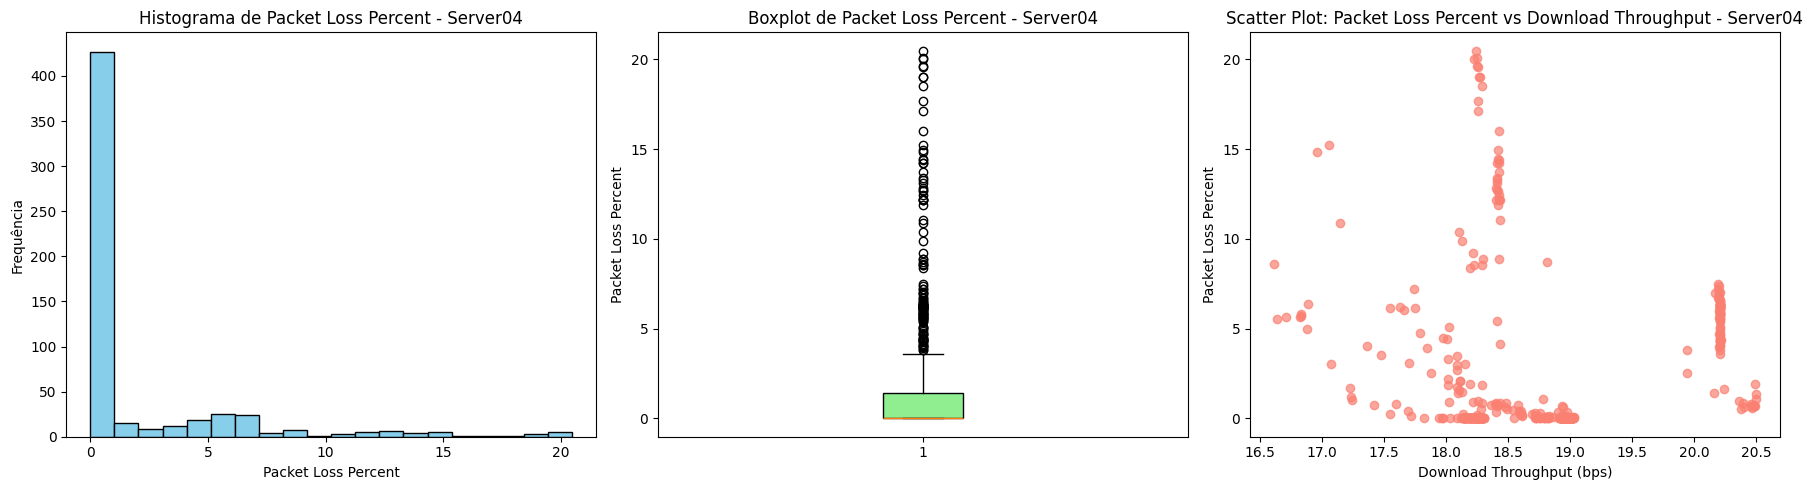

In [37]:
server04_data = final_df[final_df['server'] == 'server04']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
# Histograma
axs[0].hist(server04_data['packet_loss_percent'], bins=20, color='skyblue', edgecolor='black')
axs[0].set_title('Histograma de Packet Loss Percent - Server04')
axs[0].set_xlabel('Packet Loss Percent')
axs[0].set_ylabel('Frequência')
# Boxplot
axs[1].boxplot(server04_data['packet_loss_percent'], vert=True, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axs[1].set_title('Boxplot de Packet Loss Percent - Server04')
axs[1].set_ylabel('Packet Loss Percent')
# Scatter plot
axs[2].scatter(server04_data['download_throughput_bps'], server04_data['packet_loss_percent'], color='salmon', alpha=0.7)
axs[2].set_title('Scatter Plot: Packet Loss Percent vs Download Throughput - Server04')
axs[2].set_xlabel('Download Throughput (bps)')
axs[2].set_ylabel('Packet Loss Percent')
plt.tight_layout()
plt.show()

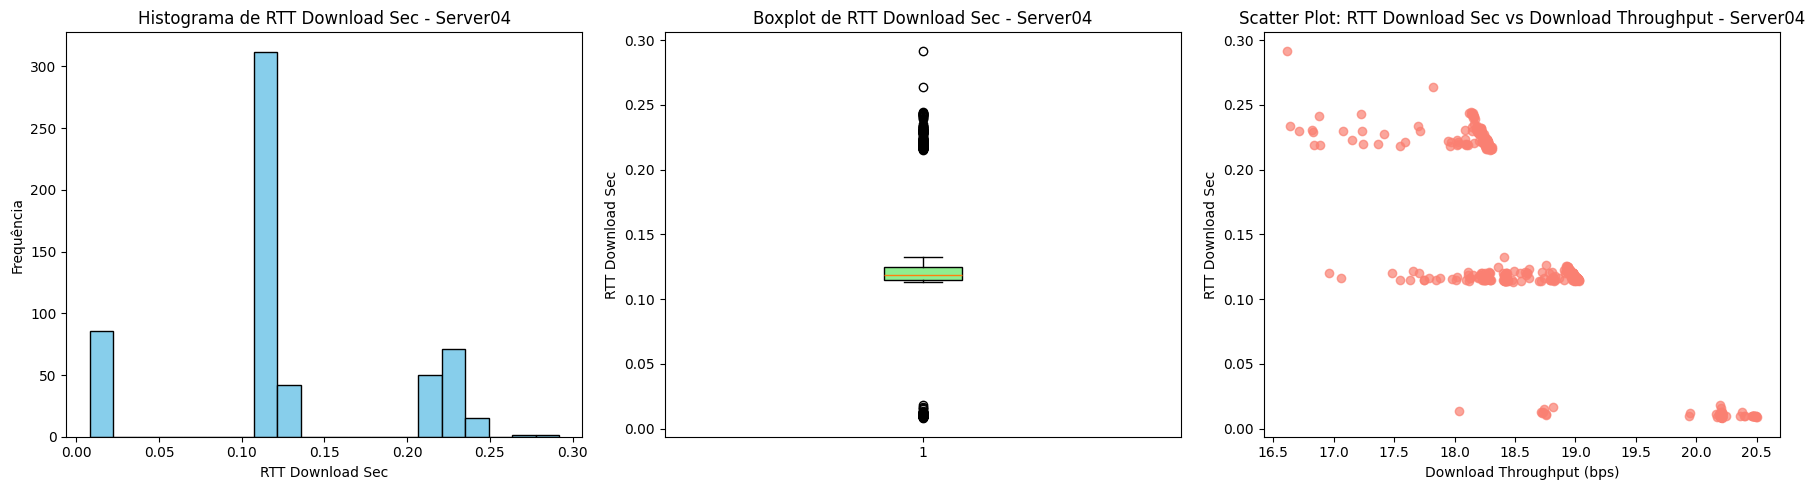

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
# Histograma
axs[0].hist(server04_data['rtt_download_sec'], bins=20, color='skyblue', edgecolor='black')
axs[0].set_title('Histograma de RTT Download Sec - Server04')
axs[0].set_xlabel('RTT Download Sec')
axs[0].set_ylabel('Frequência')
# Boxplot
axs[1].boxplot(server04_data['rtt_download_sec'], vert=True, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axs[1].set_title('Boxplot de RTT Download Sec - Server04')
axs[1].set_ylabel('RTT Download Sec')
# Scatter plot
axs[2].scatter(server04_data['download_throughput_bps'], server04_data['rtt_download_sec'], color='salmon', alpha=0.7)
axs[2].set_title('Scatter Plot: RTT Download Sec vs Download Throughput - Server04')
axs[2].set_xlabel('Download Throughput (bps)')
axs[2].set_ylabel('RTT Download Sec')
plt.tight_layout()
plt.show()